In [1]:
!pip3 install transformers 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-04-20 22:08:54--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3,3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3,26M   645KB/s    in 5,4s    

2023-04-20 22:09:01 (620 KB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [3]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Basic usage 
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [6]:
classifier("this was a great movie")

[{'label': 'POSITIVE', 'score': 0.9998722076416016}]

In [7]:
import torch 

torch.cuda.is_available()

False

In [8]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [9]:
# Use GPU 
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


AssertionError: Torch not compiled with CUDA enabled

In [11]:
df_ = pd.read_csv('./data/AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
df = df_[['airline_sentiment', 'text']].copy()

<AxesSubplot: >

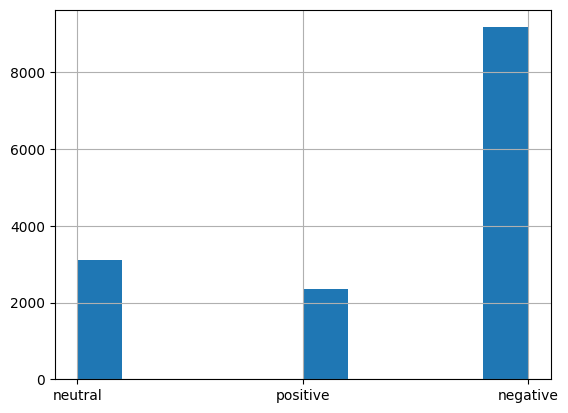

In [13]:
df['airline_sentiment'].hist()

In [14]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [15]:
target_map = {'positive': 1, 'negative': 0} 
df['target'] = df['airline_sentiment'].map(target_map)

In [16]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [17]:
len(df)

11541

In [18]:
texts = df['text'].tolist()
predictions = classifier(texts)

KeyboardInterrupt: 

In [ ]:
predictions

In [ ]:
# to compute probability for being positive
probs = [d['score'] if d['label'].startswith("P") else 1 - d['score'] for d in predictions]
probs

In [ ]:
preds = [1 if d['label'].startswith("P") else 0 for d in predictions] 

In [ ]:
preds = np.array(preds)

In [ ]:
print('acc:', np.mean(df['target'] == preds))

In [ ]:
cm = confusion_matrix(df['target'], preds, normalize='true')
cm
# large numbers along diagonal is encouraging

In [ ]:
# scikit-learn is transitioning to v1 
def plot_cm(cm): 
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index = classes, columns= classes) 
    ax = sn.heatmap(df_cm, annot=True, fmt = 'g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(df['target'], preds)
# best for document retrieval, can be inaccurate in certain situations

In [ ]:
f1_score(1 - df['target'], 1 - preds) 
# inverted score

In [ ]:
roc_auc_score(df['target'], probs) 

In [ ]:
roc_auc_score(1 - df['target'], 1 - np.array(probs))